## PhD Survey: Descriptives

In [1]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Define plotting helper function
def initialize_plot(ax):
    for pos in ('top', 'right', 'bottom', 'left'):
        ax.spines[pos].set_visible(False)

    ax.set_facecolor('ghostwhite')
    ax.grid(axis='y', color='lightgrey', linewidth=1)
    ax.set_axisbelow(True)

In [4]:
# Set plotting variables
COLOR = "darkorange"
FIGURES = "figures/descriptives/"

if not os.path.exists(FIGURES):
    os.makedirs(FIGURES)

### Read clean data

In [5]:
data = pd.read_csv("data/phd-survey-data-clean.csv", sep=";")

### Response rates over time

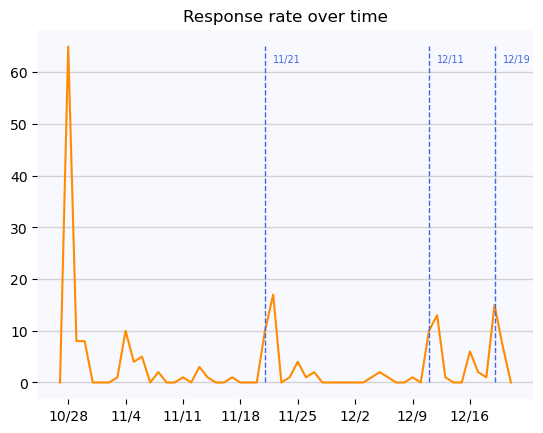

In [6]:
# Plot response rate over time
submitdate = pd.to_datetime(data.submitdate).apply(lambda x: "%d/%d" % (
                            x.month, x.day)).to_list()
# Make list for dates on which survey ran in format MM/DD
surveyrun = ["10/27", "10/28", "10/29", "10/30", "10/31"] + [
             f"11/{x}" for x in range(1, 31)] + [
             f"12/{x}" for x in range(1, 22)]

fig, ax = plt.subplots()
initialize_plot(ax)

plt.plot(surveyrun, [submitdate.count(date) for date in surveyrun], color=COLOR)

ax.set_xticks(np.arange(1, len(surveyrun), step=7))

# Create vertical lines for dates when reminders were sent
for reminder, pos in zip(["11/21", "12/11", "12/19"], [26, 46, 54]):
    ax.vlines(reminder, 0, 65, colors='royalblue', label=reminder, linestyle='--', linewidth=1)
    ax.text(pos, 62, reminder, color='royalblue', fontsize=7)

ax.set_title("Response rate over time")

plt.savefig(FIGURES + "response-rate.jpeg", dpi=300, bbox_inches='tight')

### Age, gender, nationality

In [7]:
# Print age, gender, nationality summary statistics
print("AGE")
print(f"Median: {int(data.age.median())}, Q1: {int(np.quantile(data.age.dropna(), 0.25))}, Q3: \
{int(np.quantile(data.age.dropna(), 0.75))}")

print("---")

print("GENDER")
print(f"Man: {data.gender.to_list().count('Man')}, Woman: {data.gender.to_list().count('Woman')} \
, Not say: {data.gender.to_list().count('Not say')}, Other: {data.gender.to_list().count('Other')}")
print(f"Man: {data.gender.to_list().count('Man')/len(data):.2f}, \
Woman: {data.gender.to_list().count('Woman')/len(data):.2f}, \
Not say: {data.gender.to_list().count('Not say')/len(data):.2f}, \
Other: {data.gender.to_list().count('Other')/len(data):.2f}")

print("---")

# Group non-Austrians and non-Germans into "International" group
nationality_dict = dict(data.nationality_new.value_counts())
    
print("NATIONALITY")
print(f"Austria: {nationality_dict['Austria']}, Germany: {nationality_dict['Germany']}, \
International: {nationality_dict['International']}")
print(f"Austria: {nationality_dict['Austria']/len(data):.2f}, \
Germany: {nationality_dict['Germany']/len(data):.2f}, \
International: {nationality_dict['International']/len(data):.2f}")

AGE
Median: 29, Q1: 27, Q3: 31
---
GENDER
Man: 143, Woman: 58 , Not say: 2, Other: 1
Man: 0.70, Woman: 0.28, Not say: 0.01, Other: 0.00
---
NATIONALITY
Austria: 136, Germany: 18, International: 50
Austria: 0.67, Germany: 0.09, International: 0.25


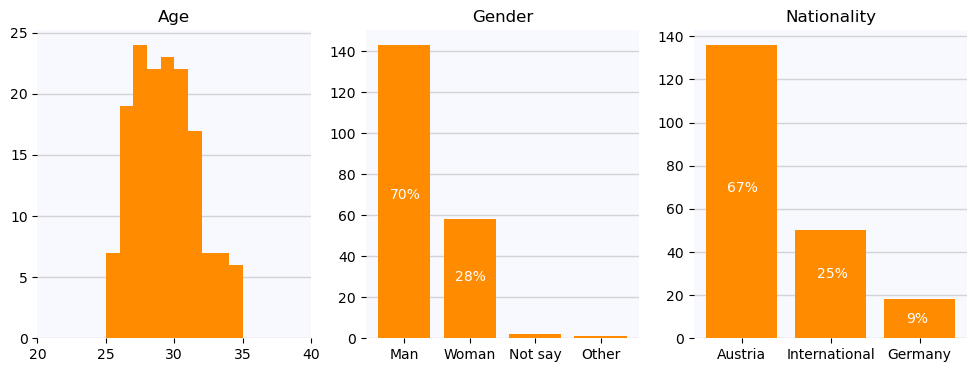

In [8]:
# Plot age, gender, nationality
fig, ax = plt.subplots(1, 3, figsize=(12,4))
initialize_plot(ax[0])
initialize_plot(ax[1])
initialize_plot(ax[2])

# Age
ax[0].hist(data.age, bins=np.arange(25, 36), color=COLOR)
ax[0].set_xticks(np.arange(20, 45, step=5))
ax[0].set_title("Age")

# Gender
ax[1].bar(dict(data.gender.value_counts()).keys(), dict(data.gender.value_counts()).values(), color=COLOR)
ax[1].text(-0.22, 68, "70%", color="white", fontsize=10)
ax[1].text(0.78, 28, "28%", color="white", fontsize=10)
ax[1].set_title("Gender")

# Nationality
ax[2].bar(nationality_dict.keys(), nationality_dict.values(), color=COLOR)
ax[2].text(-0.17, 68, "67%", color="white", fontsize=10)
ax[2].text(1.85, 7, "9%", color="white", fontsize=10)
ax[2].text(0.85, 28, "25%", color="white", fontsize=10)
ax[2].set_title("Nationality")

fig.savefig(FIGURES + "age-gender-nationality.jpeg", dpi=300, bbox_inches='tight')

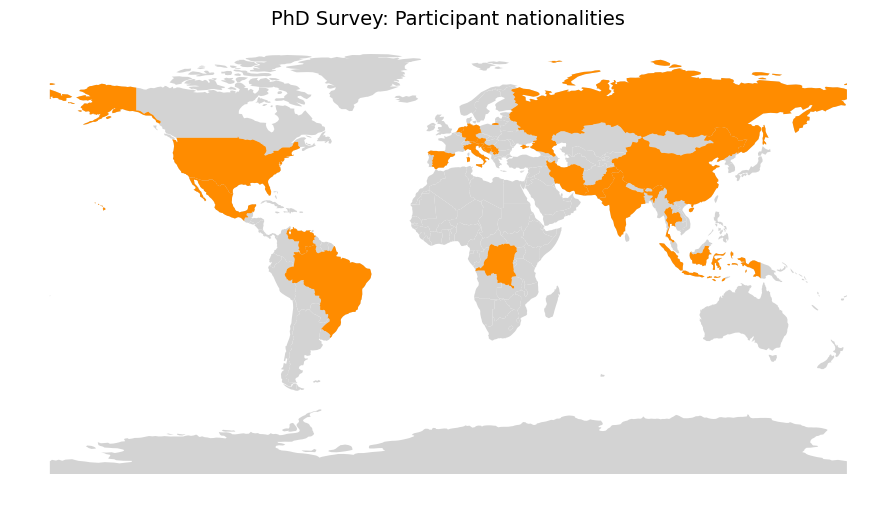

In [9]:
# Plot nationalities Yes/No for participants on world map
# Countries to plot
highlight_countries = set(data.nationality.replace({"Congo (Democratic Rep)": "Dem. Rep. Congo",
                                                    "Russian Federation": "Russia",
                                                    "Bosnia Herzegovina": "Bosnia and Herz.",
                                                    "United States": "United States of America"}))

# Load built-in world map from GeoPandas
world = gpd.read_file("ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")

# Create a column to indicate whether to highlight the country
world['highlight'] = world['NAME'].isin(highlight_countries)

fig, ax = plt.subplots(figsize=(12, 6))
world.plot(ax=ax, color='lightgray')
world[world['highlight']].plot(ax=ax, color=COLOR)

ax.set_title("PhD Survey: Participant nationalities", fontsize=14)
ax.axis('off')

plt.savefig(FIGURES + "world-map-participants.jpeg", dpi=300, bbox_inches='tight')

### Doc School, Employment status

In [10]:
# Print docschool, employment status summary statistics
print("DOCSCHOOLS")
for ds in dict(data.docschool_stud.value_counts()).keys():
    print(f"{ds}: {dict(data.docschool_stud.value_counts())[ds]}, {dict(data.docschool_stud.value_counts())[ds]/len(data):.2f}")

print("---")

# Modify employment answers based on free form answers in "other"
employment = dict(data.employ_status.value_counts())
employment["University other"] = 6
employment["UnivAss"] += 2
employment["Second job"] += 11
employment["Personal funds"] += 1
employment["Scholarship"] += 1
employment["ProjectAss TU"] += 1
employment["Other"] -= 18

employment_sorted = {k: v for k, v in sorted(employment.items(), key=lambda item: item[1], reverse=True)}

print("EMPLOYMENT STATUS")
for es in employment_sorted.keys():
    print(f"{es}: {employment_sorted[es]}, {employment_sorted[es]/len(data):.2f}")

print("---")

print("Employment status numbers will not sum up to n=204/100% because of multiple choice.")

DOCSCHOOLS
Computer Science: 28, 0.14
Physics: 26, 0.13
Mechanical Engineering: 19, 0.09
Civil Engineering Sciences: 18, 0.09
Information and Communications Engineering: 17, 0.08
Electrical Engineering: 17, 0.08
Chemistry: 16, 0.08
Molecular Biosciences and Biotechnology: 16, 0.08
Architecture: 13, 0.06
Biomedical Engineering: 11, 0.05
Mathematics and Scientific Computing: 8, 0.04
Chemical and Process Engineering: 8, 0.04
Not say: 4, 0.02
Techno-Economics: 2, 0.01
Geosciences: 1, 0.00
---
EMPLOYMENT STATUS
ProjectAss TU: 92, 0.45
UnivAss: 57, 0.28
Second job: 21, 0.10
Not say: 10, 0.05
ProjectAss Center: 8, 0.04
Scholarship: 8, 0.04
University other: 6, 0.03
Personal funds: 5, 0.02
Other: 1, 0.00
---
Employment status numbers will not sum up to n=204/100% because of multiple choice.


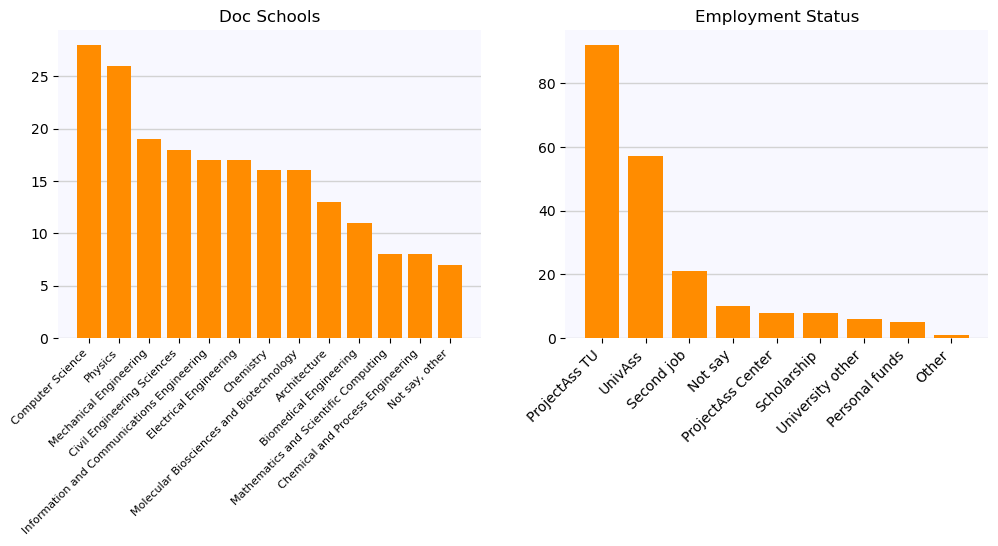

In [11]:
# Plot docschools, employment status
fig, ax = plt.subplots(1, 2, figsize=(12,4))
initialize_plot(ax[0])
initialize_plot(ax[1])

docschool_stud_new = pd.Series(["Not say, other" if x in ("Not say", "Techno-Economics", "Geosciences") else x for x in data.docschool_stud])

ax[0].bar(dict(docschool_stud_new.value_counts()).keys(), dict(docschool_stud_new.value_counts()).values(), color=COLOR)
ax[0].set_xticklabels(dict(docschool_stud_new.value_counts()).keys(), rotation=45, ha='right', fontsize=8)
ax[0].set_title("Doc Schools")

ax[1].bar(employment_sorted.keys(), employment_sorted.values(), color=COLOR)
ax[1].set_xticklabels(employment_sorted.keys(), rotation=45, ha='right')
ax[1].set_title("Employment Status")

fig.savefig(FIGURES + "docschool-employstatus.jpeg", dpi=300, bbox_inches='tight')

### Year enrolled, Year of graduation

In [12]:
# Sort year enrolled and anticipated graduation by year
def sort_dates(variable):
    d = dict(pd.Series([x.year for x in pd.to_datetime(data[variable])]).value_counts())
    
    k = list(d.keys())
    k.sort()
    d_sorted = {i: d[i] for i in k}
    
    return d

enrolled_sorted = sort_dates("enrol")
graduate_sorted = sort_dates("graduate")

In [13]:
# Print year enrolled, anticipated graduation summary statistics
print("YEAR ENROLLED")
for ye in enrolled_sorted.keys():
    print(f"{ye}: {enrolled_sorted[ye]}, {enrolled_sorted[ye]/len(data):.2f}")

print("---")

print("YEAR GRADUATE")
for yg in graduate_sorted.keys():
    print(f"{yg}: {graduate_sorted[yg]}, {graduate_sorted[yg]/len(data):.2f}")

YEAR ENROLLED
2022: 46, 0.23
2023: 44, 0.22
2021: 40, 0.20
2024: 36, 0.18
2020: 20, 0.10
2019: 11, 0.05
2018: 3, 0.01
2017: 2, 0.01
2016: 2, 0.01
---
YEAR GRADUATE
2025: 81, 0.40
2026: 58, 0.28
2027: 39, 0.19
2028: 12, 0.06
2024: 12, 0.06
2029: 2, 0.01


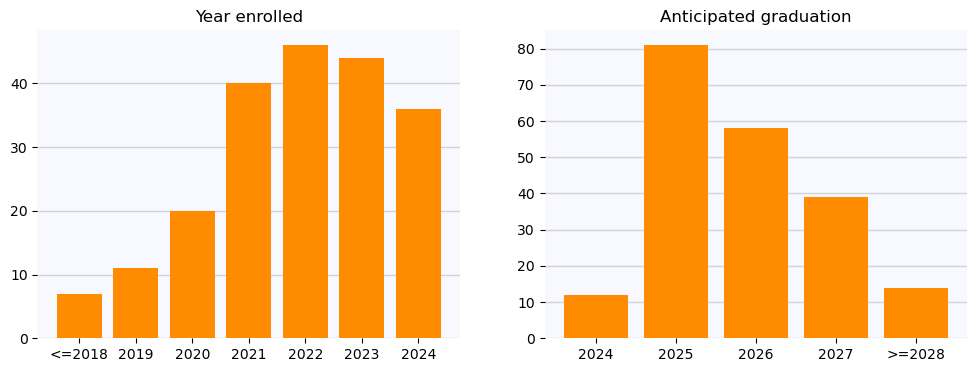

In [14]:
# Plot year enrolled, anticipated graduation
fig, ax = plt.subplots(1, 2, figsize=(12,4))
initialize_plot(ax[0])
initialize_plot(ax[1])

enrolled_new = {"<=2018": 7, "2019": 11, "2020": 20, "2021": 40, "2022": 46, "2023": 44, "2024": 36}
graduate_new = {"2024": 12, "2025": 81, "2026": 58, "2027": 39, ">=2028": 14}

ax[0].bar(enrolled_new.keys(), enrolled_new.values(), color=COLOR)
ax[0].set_title("Year enrolled")

ax[1].bar(graduate_new.keys(), graduate_new.values(), color=COLOR)
ax[1].set_title("Anticipated graduation")

fig.savefig(FIGURES + "enroll-graduate.jpeg", dpi=300, bbox_inches='tight')

### Survey completion time

In [15]:
print(
f"Median time spent on survey: {(round(data.time_spent/60)).median()} minutes")

Median time spent on survey: 13.0 minutes


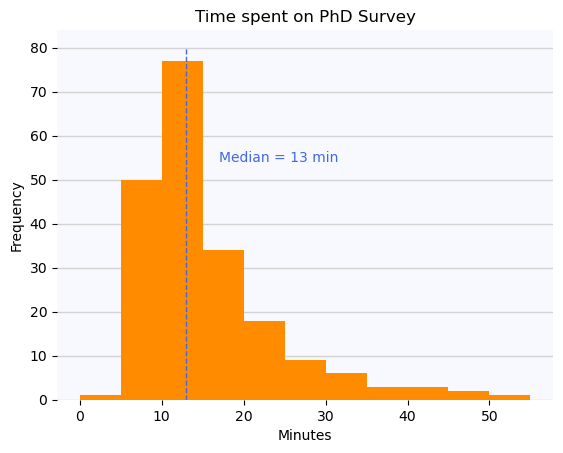

In [16]:
fig, ax = plt.subplots()
initialize_plot(ax)

ax.hist(data.time_spent/60, bins=np.arange(0, 56, step=5), color=COLOR)
ax.set_title("Time spent on PhD Survey")
ax.set_xlabel("Minutes")
ax.set_ylabel("Frequency")

ax.vlines(13, 0, 80, colors='royalblue', linestyle='--', linewidth=1)
ax.text(17, 54, "Median = 13 min", color="royalblue", fontsize=10)

fig.savefig(FIGURES + "completion-time.jpeg", dpi=300, bbox_inches='tight')

### Free feedback (survey end)

In [17]:
for feedback in data.free_text_end.dropna():
    print(feedback)

Dear PhD Union! Thanks for all the effort you put into this survey.
Nope.
8 years ago I experienced a real tough time aborting my PhD according to conflicts with my supervisor. Afterwards I really struggled with myself. After recovering I started to teach at FH JOANNEUM which really help me to gain self confidence again. 2022 I had the opportunity to do my PhD again within a FWF project, I applied for it and now I am glad that I took the chance (most of the time :-) ) 

For me personally, If I could talk to my 8-years-ago-self, I would say "speak up", don't let yourself get blamed for not doing enough.  (which was not the case, afterall). Anyways the most thing I am struggeling with at the moment is the resulting overdue of my semesters I needed for the PhD and paying the full fee, but I guess I will make it as well. 

Thanks for this survey  

A lot of hours were spent on compiling information. Which courses are ok to take? When do the institutional PhD seminars (that we have to parti